In [373]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix

In [320]:
df = pd.read_csv("l2_final",index_col = 0)

In [321]:
df

,label,hop_count,uses_url_shortener,num_script_tags,has_password_field,num_external_links,dom_depth,final_url_tld_freq
0,benign,1,0,15,0,62,13,9
1,benign,0,0,50,0,0,7,26
2,benign,1,0,16,0,14,20,715
3,phishing,0,0,-1,-1,-1,-1,3
6,phishing,0,0,20,0,409,23,3
...,...,...,...,...,...,...,...,...
2010,benign,0,0,4,0,0,4,715
2012,phishing,0,0,-1,-1,-1,-1,715
2013,phishing,0,0,-1,-1,-1,-1,17
2016,phishing,0,0,-1,-1,-1,-1,37


In [322]:
#final_url_tld_freq, to show how rare tld is, labelencoding wouldn't make sense cause .com is not greater than .xyz but phishing websites tend to use rare tld
df['target'] = df['label'].map({'phishing': 1, 'benign': 0})

In [323]:
X = df.drop(columns=['label', 'target'])
y = df['target']


In [324]:
X_train

,hop_count,uses_url_shortener,num_script_tags,has_password_field,num_external_links,dom_depth,final_url_tld_freq
544,1,0,59,0,39,29,12
1272,0,0,35,0,12,24,715
611,1,0,3,0,0,13,2
757,0,0,-1,-1,-1,-1,715
1235,0,0,-1,-1,-1,-1,715
...,...,...,...,...,...,...,...
1089,0,0,5,0,0,10,6
78,0,0,34,0,19,23,715
1041,1,0,11,0,10,21,715
2016,0,0,-1,-1,-1,-1,37


In [325]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [326]:
# tld_means = y_train.groupby(X_train['final_url_tld_freq']).mean()

# # 2. Define Global Mean (Fallback)
# # If a TLD appears in the test set but wasn't in the training set (e.g., '.io'),
# # we fill it with the average phishing rate of the entire training set.
# global_mean = y_train.mean()

# # 3. Map the Means to Create the New Feature
# # We create a new column 'tld_encoded' and drop the original 'final_url_tld'
# X_train['tld_encoded'] = X_train['final_url_tld_freq'].map(tld_means).fillna(global_mean)
# X_test['tld_encoded'] = X_test['final_url_tld_freq'].map(tld_means).fillna(global_mean)

# # 4. Drop the Original Categorical Column
# X_train = X_train.drop(columns=['final_url_tld_freq'])
# X_test = X_test.drop(columns=['final_url_tld_freq'])
# X_train = X_train.drop('final_url_tld', axis =1 )
# X_test = X_test.drop('final_url_tld', axis =1 )

In [329]:
#scaler = StandardScaler()
#scaler = RobustScaler()
#X_train_scaled = scaler.fit_transform(X_train)
#X_test_scaled = scaler.transform(X_test)
#joblib.dump(scaler, 'scaler.joblib')

In [351]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf = RandomForestClassifier(random_state=42)


In [352]:
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, 
                           cv=5, n_jobs=-1, verbose=2, scoring='f1')

# 4. Fit the search (This might take 1-2 minutes)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20, 30],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200]},
             scoring='f1', verbose=2)

In [353]:
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

print(f"\nBest Parameters: {best_params}")
print(f"Best Cross-Validation F1 Score: {grid_search.best_score_:.4f}")

# --- Cell 4: Evaluate the Best Model ---

print("\n--- Final Test Set Evaluation (Best Model) ---")
y_pred = best_model.predict(X_test)

print(f"Accuracy: {accuracy_score(y_test, y_pred)*100:.2f}%")
print("\n" + classification_report(y_test, y_pred, target_names=['Safe', 'Phishing']))



Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best Cross-Validation F1 Score: 0.7978

--- Final Test Set Evaluation (Best Model) ---
Accuracy: 79.20%

              precision    recall  f1-score   support

        Safe       0.83      0.79      0.81       139
    Phishing       0.75      0.79      0.77       111

    accuracy                           0.79       250
   macro avg       0.79      0.79      0.79       250
weighted avg       0.79      0.79      0.79       250



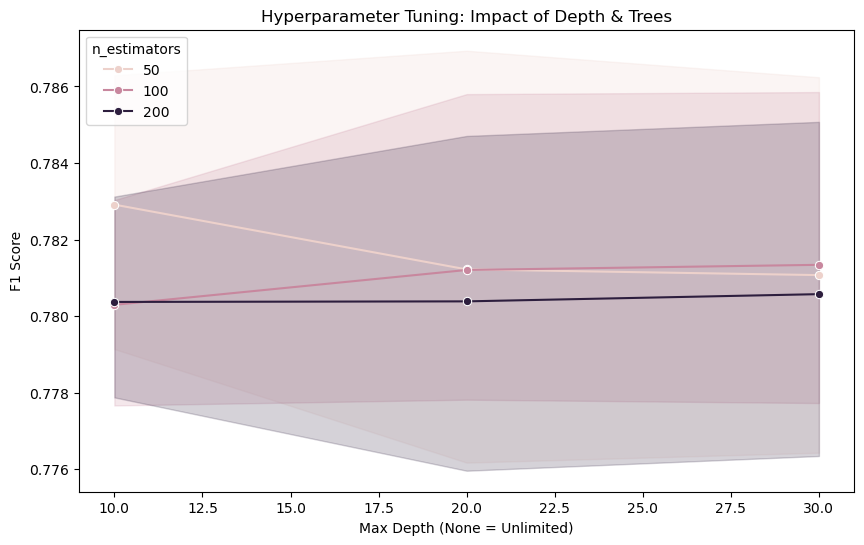

In [354]:
results_df = pd.DataFrame(grid_search.cv_results_)

# Plot performance vs. Max Depth
plt.figure(figsize=(10, 6))
sns.lineplot(data=results_df, x='param_max_depth', y='mean_test_score', hue='param_n_estimators', marker='o')
plt.title('Hyperparameter Tuning: Impact of Depth & Trees')
plt.xlabel('Max Depth (None = Unlimited)')
plt.ylabel('F1 Score')
plt.legend(title='n_estimators')
plt.show()

Starting XGBoost Grid Search...
Fitting 5 folds for each of 216 candidates, totalling 1080 fits


C:\Users\djibr\anaconda3\Lib\site-packages\xgboost\training.py:199: UserWarning: [16:57:51] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'scale_pos_weight': 1, 'subsample': 1.0}
Best Cross-Val F1 Score: 0.8066

--- Final Test Set Evaluation (XGBoost) ---
Accuracy: 79.60%

              precision    recall  f1-score   support

        Safe       0.82      0.81      0.82       139
    Phishing       0.77      0.77      0.77       111

    accuracy                           0.80       250
   macro avg       0.79      0.79      0.79       250
weighted avg       0.80      0.80      0.80       250


--- XGBoost Feature Importance ---
              feature  importance
4  num_external_links    0.318189
0           hop_count    0.302402
5           dom_depth    0.111131
6  final_url_tld_freq    0.098660
3  has_password_field    0.092934
2     num_script_tags    0.076683
1  uses_url_shortener    0.000000


C:\Users\djibr\AppData\Local\Temp\ipykernel_29200\2481821199.py:65: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importances, x='importance', y='feature', palette='magma')


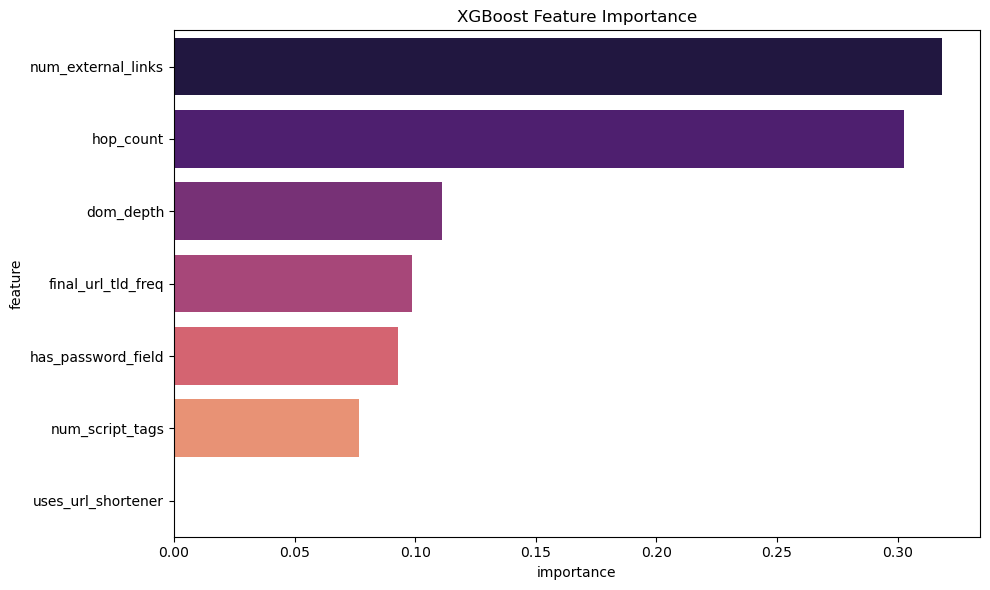

Saved 'l2_l3_xgboost_model.pkl'


In [355]:
# --- Cell 2: XGBoost Grid Search ---

print("Starting XGBoost Grid Search...")

# 1. Define the Hyperparameter Grid
# These are standard ranges for tuning XGBoost
param_grid = {
    'n_estimators': [50, 100, 200],       # Number of boosting rounds
    'max_depth': [3, 5, 7],               # Tree depth (lower is better for small data)
    'learning_rate': [0.01, 0.1, 0.2],    # Step size shrinkage (lower = slower but robust)
    'subsample': [0.8, 1.0],              # Randomly sample rows to prevent overfitting
    'colsample_bytree': [0.8, 1.0],       # Randomly sample columns (features)
    'scale_pos_weight': [1, 1.2]          # Handling class imbalance (minor tweak)
}

# 2. Initialize the Model
xgb = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=42
)

# 3. Setup Grid Search (5-Fold CV)
grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    cv=5,
    n_jobs=-1,
    verbose=1,
    scoring='f1'  # We optimize for F1-score, not just accuracy
)

# 4. Fit
# (Make sure you are using X_train_scaled and y_train from your previous cells)
grid_search.fit(X_train, y_train)

# 5. Results
best_params = grid_search.best_params_
best_xgb = grid_search.best_estimator_

print(f"\nBest Parameters: {best_params}")
print(f"Best Cross-Val F1 Score: {grid_search.best_score_:.4f}")

# --- Cell 3: Evaluation ---

print("\n--- Final Test Set Evaluation (XGBoost) ---")
y_pred = best_xgb.predict(X_test)

print(f"Accuracy: {accuracy_score(y_test, y_pred)*100:.2f}%")
print("\n" + classification_report(y_test, y_pred, target_names=['Safe', 'Phishing']))

# --- Cell 4: Feature Importance Plot ---

# XGBoost provides its own importance metric (gain)
importances = pd.DataFrame({
    'feature': X_train.columns, # Assuming 'X' is your original unscaled dataframe with column names
    'importance': best_xgb.feature_importances_
}).sort_values('importance', ascending=False)

print("\n--- XGBoost Feature Importance ---")
print(importances)

plt.figure(figsize=(10, 6))
sns.barplot(data=importances, x='importance', y='feature', palette='magma')
plt.title('XGBoost Feature Importance')
plt.tight_layout()
plt.show()

# --- Cell 5: Save the Model ---
joblib.dump(best_xgb, 'l2_l3_xgboost_model.pkl')
print("Saved 'l2_l3_xgboost_model.pkl'")

In [375]:
cm = confusion_matrix(y_test,y_pred)



In [376]:
cm

array([[113,  26],
       [ 25,  86]])

In [357]:
t = [[0. ,  0.,    0.,    0.,    0.125, 0.,    0.   ]]

In [358]:
best_xgb.predict_proba(t)

array([[0.15943009, 0.8405699 ]], dtype=float32)

In [366]:
# google.com
data = {'hop_count': 1, 'uses_url_shortener': 0, 'num_script_tags': 6, 'has_password_field': 0, 'num_external_links': 3, 'dom_depth': 11, 'final_url_tld_freq':715}

In [360]:
feat_df = pd.DataFrame(data, index = [0],columns = feature_columns)

In [371]:
feat_df

,hop_count,uses_url_shortener,num_script_tags,has_password_field,num_external_links,dom_depth,final_url_tld_freq
0,1,0,6,0,3,11,715


In [370]:
best_xgb.predict_proba(feat_df)

array([1])

In [363]:
print("Provided feature order:", X_train.columns.tolist())


Provided feature order: ['hop_count', 'uses_url_shortener', 'num_script_tags', 'has_password_field', 'num_external_links', 'dom_depth', 'final_url_tld_freq']


In [364]:
t = X_train.columns

In [365]:
feature_columns = [
            'hop_count', 'uses_url_shortener', 'num_script_tags',
            'has_password_field', 'num_external_links', 'dom_depth',
            'final_url_tld_freq'
        ]

In [347]:
feature_columns

['hop_count',
 'uses_url_shortener',
 'num_script_tags',
 'has_password_field',
 'num_external_links',
 'dom_depth',
 'final_url_tld_freq']

In [348]:
type(t)

pandas.core.indexes.base.Index

In [349]:
feat_scaled

array([[ 0.39188643, -0.07095947, -0.36986596,  0.4492176 , -0.25651675,
        -0.01113497,  0.85547175]])

In [350]:
best_xgb.predict_proba(t)

ValueError: Please reshape the input data into 2-dimensional matrix.

In [ ]:
best_xgb.predict_proba(feat_scaled)

In [ ]:
best_model.predict_proba(t)

In [ ]:
best_model.predict_proba(feat_scaled)